# Covariances and correlations
This notebook continues where [the previous notebook dedicated to volatilities](https://github.com/ilchen/RMaFI/blob/master/ch10.ipynb) left off. Even though estimating and forecasting covariances is similar to volatilities, there are important nuances.

The most important is how we estimate λ for EMWA and ω, α, and β for GARCH(1, 1) so that a resultant variance-covariance matrices are consistent? The way to do it is to use the λ parameter that in aggregate works best for the variances. In other words, if we want to measure volatilities and correlation for two assets, we should implement EWMA constraining λ to be the same for the two variances and choose the λ that maximizes the total of the two likelihoods as given by equation:
$$
\sum_{i=1}^{m}\left[-\ln(\nu_{i}) - \frac{u_{i}^{2}}{\nu_{i}}\right]
$$
where:
* $u_{i} = \ln\frac{S_{i}}{S_{i-1}} \sim \frac{S_{i} - S_{i-1}}{S_{i-1}}$ is the continuously compounded return per day, which is almost exactly the same as the percentage change in the market variable whose volatility we are estimating between the end of day i-1 and the end of day i; and 
* $\nu_{i} = \sigma_{i}^{2}$ is the estimate of the variance rate of the market variable for day i made at the end of day i-1.

It implies that we don't consider maximizing the likelihood for covariance estimations, only for variances.

To accomplish this I modified [the volatility parameters estimator classes](https://github.com/ilchen/RMaFI/blob/master/volatility/parameter_estimators.py) so that they can take prices for multiple assets and use the maximum likelihood method that maximizes the total of the likelihoods.

I also created [classes to track and forecast covariances](https://github.com/ilchen/RMaFI/blob/master/correlations/covariance_trackers.py). Once you can track covariances and volatilities, you can easily translate that into correlations. Since all my tracker classes use Pandas DataFrames and Series, it all works seamlessly.

In this notebook I analyze correlations between:
* Bitcoin and SP500
* Bitcoin and NASDAQ 100 Technology Sector
* Bitcoin and Gold
* Gold and US Real Riskless Yields as represented by yields on TIPS

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the volatility and correlations modules
# in the cell below will fail
#!git clone -l -s https://github.com/ilchen/RMaFI.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and yfinance
# !pip install pandas-datareader -U
# !pip install yfinance -U

In [2]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import pandas_datareader.data as web
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from volatility import parameter_estimators, volatility_trackers
from correlations import covariance_trackers

## Estimating  correlation between SP500, NASDAQ 100 Technology Sector, and Bitcoin using EWMA
It is believed that the price of Bitcoin appears closely correlated with tech stocks. Yet it is only moderately correlated with the broader market. Let's put this to the test.

In [3]:
# A kludge for pandas-datareader not being able to cope with latest Yahoo-Finance changes
import yfinance as yfin
yfin.pdr_override()

In [4]:
start = BDay(1).rollforward(date(2020, 1, 1)).date()
end = date.today()

In [5]:
data = web.get_data_yahoo(['^GSPC', '^NDXT', 'BTC-USD'], start, end)

# Get rid of possible differences in timezone offsets when aggregating data from different trading venues
asset_prices = data['Adj Close'].resample('D').first()
asset_prices.index = asset_prices.index.tz_localize(None)

# We need to drop NaN rows as not all assets trade every day like the BTC
asset_prices_sp500 = asset_prices['^GSPC'].dropna()
asset_prices_nq100 = asset_prices['^NDXT'].dropna()
asset_prices_btc = asset_prices['BTC-USD'].dropna()

[*********************100%***********************]  3 of 3 completed


In [6]:
# Searching for a λ that maximizes the likelihood of witnessing the percentage changes of SP500, NASDAQ 100, and BTC
combined_ewma = parameter_estimators.EWMAParameterEstimator(asset_prices)

# Reusing it to track the volatilities of these two assets and their covariane 
sp500_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_sp500)
nq100_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_nq100)
btc_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_btc)

# Covariance between SP500 and BTC
covariance_tracker_sp500_btc = covariance_trackers.EWMACovarianceTracker(combined_ewma.lamda,
                                                                         asset_prices[['^GSPC', 'BTC-USD']])

# Covariance between NASDAQ 100 Technology sector and BTC
covariance_tracker_nq100_btc = covariance_trackers.EWMACovarianceTracker(combined_ewma.lamda,
                                                                         asset_prices[['^NDXT', 'BTC-USD']])

Objective function: 20377.86642 after 15 iterations


In [7]:
print('\u03BB that maximizes the likelihood of percentage changes in SP500, NASDAQ 100, and BTC-USD: %.7f'
      % combined_ewma.lamda)

λ that maximizes the likelihood of percentage changes in SP500, NASDAQ 100, and BTC-USD: 0.9445330


Correlation can be obtained by dividing the covariance by a product of daily volatilities (daily standard deviations). Pandas Series objects make this trivial.

In [8]:
sp500_vols = sp500_vol_tracker.get_daily_volatilities()
nq100_vols = nq100_vol_tracker.get_daily_volatilities()
btc_vols = btc_vol_tracker.get_daily_volatilities()
covariances_sp500_btc = covariance_tracker_sp500_btc.get_covariances()
correlations_sp500_btc = covariances_sp500_btc / (sp500_vols * btc_vols)
correlations_sp500_btc.dropna(inplace=True)

covariances_nq100_btc = covariance_tracker_nq100_btc.get_covariances()
correlations_nq100_btc = covariances_nq100_btc / (nq100_vols * btc_vols)
correlations_nq100_btc.dropna(inplace=True)

In [9]:
# Select dates on which all the three asset classes have traded
common_dates = asset_prices_btc.index.intersection(asset_prices_sp500.index).intersection(asset_prices_nq100.index)

Correlations change, in fact the correlation between two asset classes is a ramdom process. For some asset classes such a process has a well-defined long-term mean (this is tipically the case when there's a clearly defined economic relationship between them), for some not. The below expression tries to calculate overall correlations for the entire period starting from January 2020. If the correlation between BTC and NASDAQ 100 Tech Sector doesn't have a well-defined mean, such overall correlations will be pretty meaningless.

In [10]:
overall_btc_sp500_corr = asset_prices_btc[common_dates].corr(asset_prices_sp500[common_dates])
overall_btc_nq100_corr = asset_prices_btc[common_dates].corr(asset_prices_nq100[common_dates])

### Visualizing the correlation between SP500, NASDAQ 100 Technology Sector, and Bitcoin using EWMA

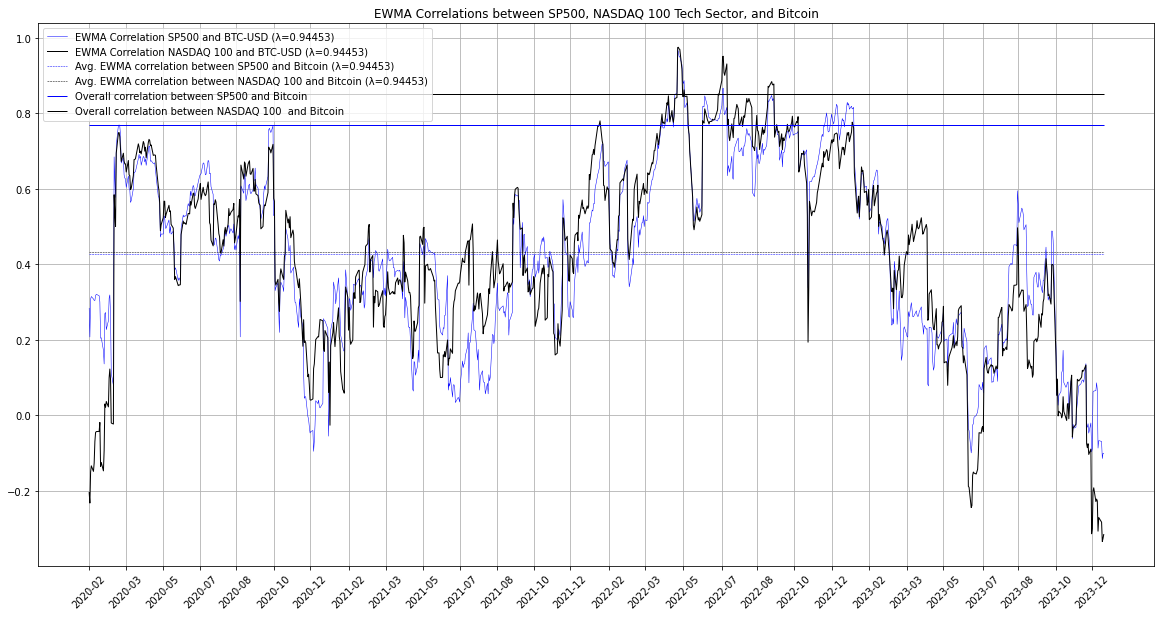

In [11]:
days_to_skip = 20 # Skipping the first 20 datapoints

x = covariance_tracker_sp500_btc.get_dates()[days_to_skip:]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x, correlations_sp500_btc[days_to_skip:],
        label='EWMA Correlation SP500 and BTC-USD (λ=%.5f)' % combined_ewma.lamda , linewidth=.5, color='b')
ax.plot(x, correlations_nq100_btc[days_to_skip:],
        label='EWMA Correlation NASDAQ 100 and BTC-USD (λ=%.5f)' % combined_ewma.lamda , linewidth=1, color='k')
ax.title.set_text('EWMA Correlations between SP500, NASDAQ 100 Tech Sector, and Bitcoin')
ax.hlines(correlations_sp500_btc[days_to_skip:].mean(),
          label='Avg. EWMA correlation between SP500 and Bitcoin (λ=%.5f)' % combined_ewma.lamda,
          xmin=x[0], xmax=x[-1], linestyle='--', linewidth=.5, color='b')
ax.hlines(correlations_nq100_btc[days_to_skip:].mean(),
          label='Avg. EWMA correlation between NASDAQ 100 and Bitcoin (λ=%.5f)' % combined_ewma.lamda,
          xmin=x[0], xmax=x[-1], linestyle='--', linewidth=.5, color='k')
ax.hlines(overall_btc_sp500_corr, label='Overall correlation between SP500 and Bitcoin',
          xmin=x[0], xmax=x[-1], linestyle='-', linewidth=1, color='b')
ax.hlines(overall_btc_nq100_corr, label='Overall correlation between NASDAQ 100  and Bitcoin',
          xmin=x[0], xmax=x[-1], linestyle='-', linewidth=1, color='k')
ax.legend()
ax.grid(True)
ax.set_xticks(x[::36])
_ = ax.set_xticklabels(x[::36].strftime('%Y-%m'), rotation=45)

In [12]:
print('Avg. EWMA correlation between SP500 and Bitcoin: {:.4f}'.format(correlations_sp500_btc[days_to_skip:].mean()))
print('Avg. EWMA correlation between NASDAQ 100 and Bitcoin: {:.4f}'.format(correlations_nq100_btc[days_to_skip:].mean()))

Avg. EWMA correlation between SP500 and Bitcoin: 0.4289
Avg. EWMA correlation between NASDAQ 100 and Bitcoin: 0.4332


The fact that the overall correlation between BTC and NASDAQ 100 is so much different from the average EWMA correlation is an indication that there's no well-defined mean value that it reverts to.

The positive correlation manifests itself if we plot Bitcoin price changes against those of SP500 or NASDAQ 100 Technology Sector. They tend to have similar peaks and troughs.

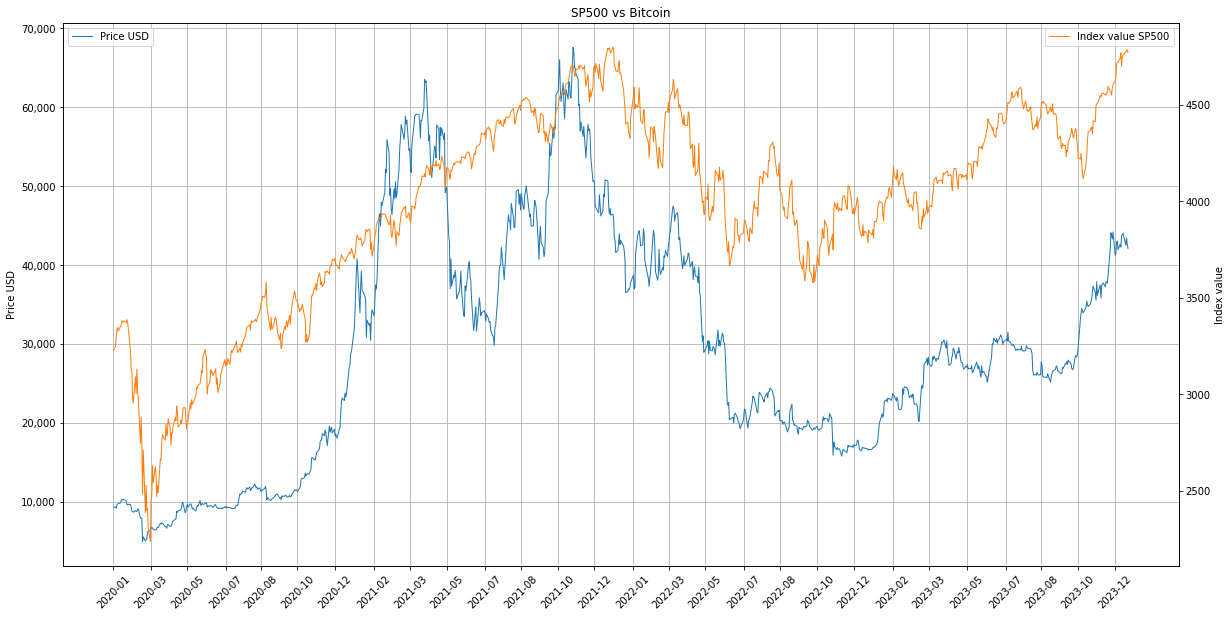

In [13]:
left_lbl, right_lbl = 'Price USD', 'Index value'

x = common_dates[days_to_skip:]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x, asset_prices_btc[common_dates][days_to_skip:], label=left_lbl, linewidth=1, color='#1f77b4')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, asset_prices_sp500[common_dates][days_to_skip:], label=right_lbl + ' SP500', linewidth=1, color='#ff7f0e')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True)
ax.set_ylabel(left_lbl)
ax2.set_ylabel(right_lbl)
ax.set_xticks(x[::36])
ax.title.set_text('SP500 vs Bitcoin')
ax.yaxis.set_major_formatter('{x:,.0f}')
_ = ax.set_xticklabels(x[::36].strftime('%Y-%m'), rotation=45)

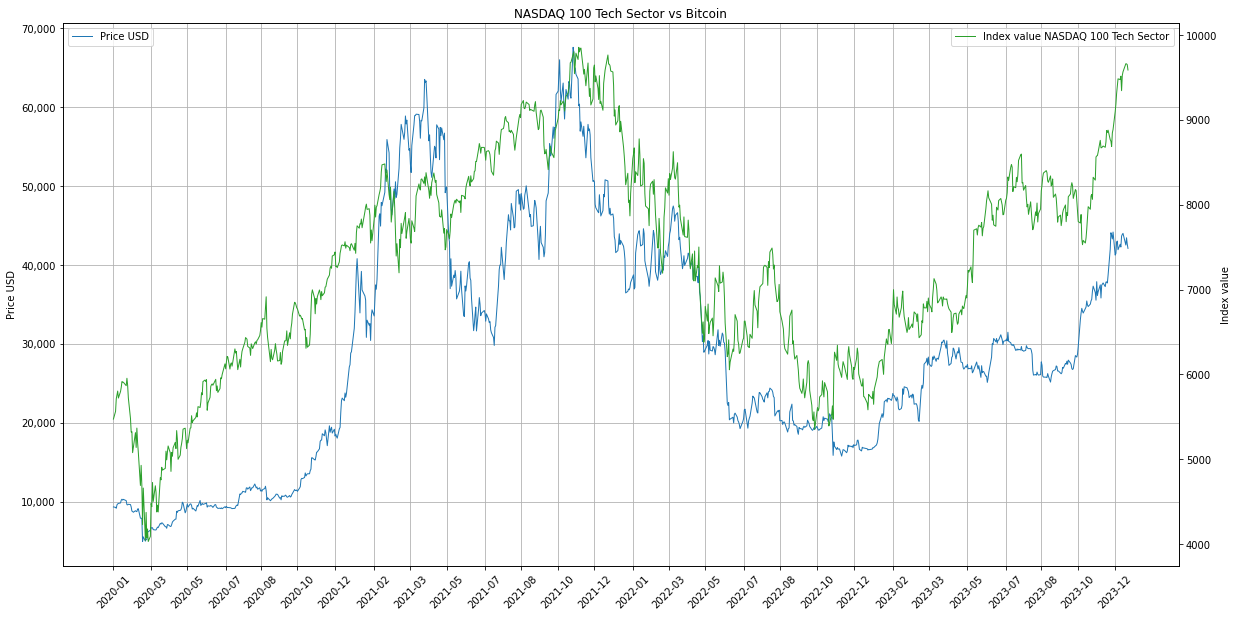

In [14]:
left_lbl, right_lbl = 'Price USD', 'Index value'

x = common_dates[days_to_skip:]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x, asset_prices_btc[common_dates][days_to_skip:], label=left_lbl, linewidth=1, color='#1f77b4')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, asset_prices_nq100[common_dates][days_to_skip:], label=right_lbl + ' NASDAQ 100 Tech Sector', linewidth=1,
         color='#2ca02c')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True)
ax.set_ylabel(left_lbl)
ax2.set_ylabel(right_lbl)
ax.set_xticks(x[::36])
ax.title.set_text('NASDAQ 100 Tech Sector vs Bitcoin')
ax.yaxis.set_major_formatter('{x:,.0f}')
_ = ax.set_xticklabels(x[::36].strftime('%Y-%m'), rotation=45)

## Estimating  correlation between Bitcoin and Gold using EWMA
Bitcoin is frequently touted as the _digital gold_. Let's put to the test how its prices correlates with that of real gold.

In [15]:
data = web.get_data_yahoo(['BTC-USD', 'GC=F'], start, end)

# Get rid of possible differences in timezone offsets when aggregating data from different trading venues
asset_prices = data['Adj Close'].resample('D').first()
asset_prices.index = asset_prices.index.tz_localize(None)

# We need to drop NaN rows as not all assets trade every day like the BTC
asset_prices_btc = asset_prices['BTC-USD'].dropna()
asset_prices_gold = asset_prices['GC=F'].dropna()

[*********************100%***********************]  2 of 2 completed


In [16]:
# Searching for a λ that maximizes the likelihood of witnessing the percentage changes of BTC and Gold
combined_ewma = parameter_estimators.EWMAParameterEstimator(asset_prices)

# Reusing it to track the volatilities of these two assets and their covariane 
btc_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_btc)

gold_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_gold)

# Covariance between Gold and BTC
covariance_tracker_gold_btc = covariance_trackers.EWMACovarianceTracker(combined_ewma.lamda,
                                                                        asset_prices[['GC=F', 'BTC-USD']])

Objective function: 13741.31407 after 17 iterations


In [17]:
print('\u03BB that maximizes the likelihood of percentage changes in Gold and BTC-USD: %.7f'
      % combined_ewma.lamda)

λ that maximizes the likelihood of percentage changes in Gold and BTC-USD: 0.9850325


In [18]:
gold_vols = gold_vol_tracker.get_daily_volatilities()
btc_vols = btc_vol_tracker.get_daily_volatilities()
covariances_gold_btc = covariance_tracker_gold_btc.get_covariances()
correlations_gold_btc = covariances_gold_btc / (gold_vols * btc_vols)
correlations_gold_btc.dropna(inplace=True)

In [19]:
# Select dates on which all the three asset classes have traded
common_dates = asset_prices_btc.index.intersection(asset_prices_gold.index)

In [20]:
overall_gold_btc_corr = asset_prices_btc[common_dates].corr(asset_prices_gold[common_dates])

### Visualizing the correlation between Gold and Bitcoin using EWMA

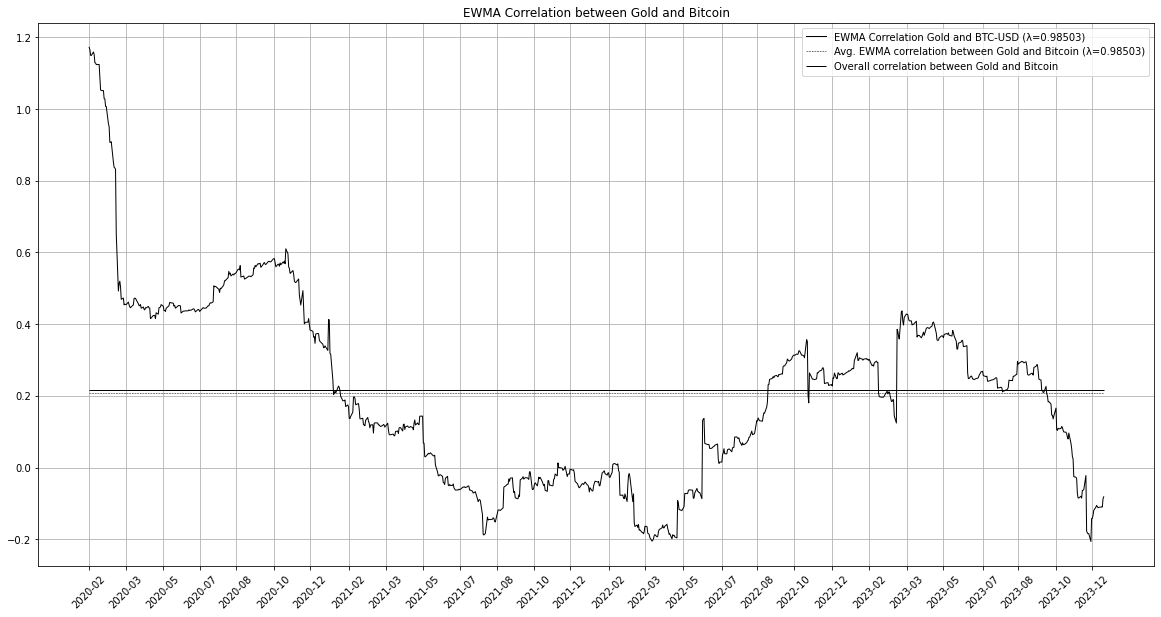

In [21]:
x = covariance_tracker_gold_btc.get_dates()[days_to_skip:]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x, correlations_gold_btc[days_to_skip:],
        label='EWMA Correlation Gold and BTC-USD (λ=%.5f)' % combined_ewma.lamda , linewidth=1, color='k')
ax.title.set_text('EWMA Correlation between Gold and Bitcoin')
ax.hlines(correlations_gold_btc[days_to_skip:].mean(),
          label='Avg. EWMA correlation between Gold and Bitcoin (λ=%.5f)' % combined_ewma.lamda,
          xmin=x[0], xmax=x[-1], linestyle='--', linewidth=.5, color='k')
ax.hlines(overall_gold_btc_corr, label='Overall correlation between Gold and Bitcoin',
          xmin=x[0], xmax=x[-1], linestyle='-', linewidth=1, color='k')
ax.legend()
ax.grid(True)
ax.set_xticks(x[::36])
_ = ax.set_xticklabels(x[::36].strftime('%Y-%m'), rotation=45)

In [22]:
print('Avg. correlation between Gold and Bitcoin: {:.4f}'.format(correlations_gold_btc[days_to_skip:].mean()))

Avg. correlation between Gold and Bitcoin: 0.2072


The small positive correlation manifests itself if we plot Gold price changes against those of Bitcoin.

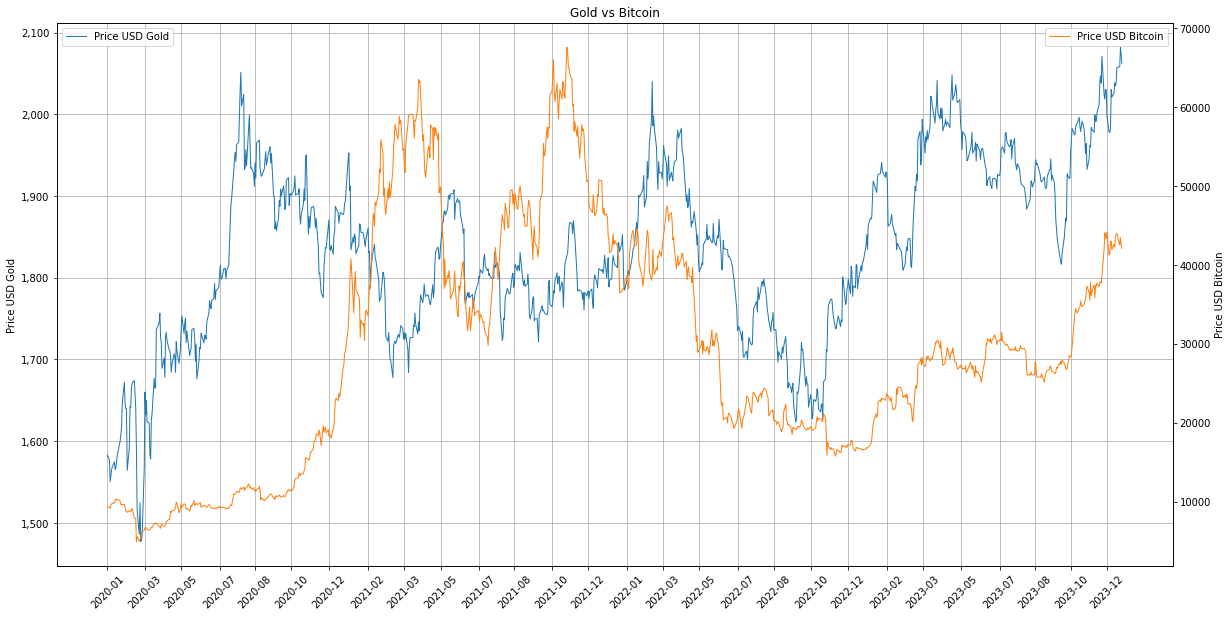

In [23]:
left_lbl, right_lbl = 'Price USD Gold', 'Price USD Bitcoin'

x = common_dates[days_to_skip:]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x, asset_prices_gold[common_dates][days_to_skip:], label=left_lbl, linewidth=1, color='#1f77b4')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, asset_prices_btc[common_dates][days_to_skip:], label=right_lbl, linewidth=1, color='#ff7f0e')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True)
ax.set_ylabel(left_lbl)
ax2.set_ylabel(right_lbl)
ax.set_xticks(x[::36])
ax.title.set_text('Gold vs Bitcoin')
ax.yaxis.set_major_formatter('{x:,.0f}')
_ = ax.set_xticklabels(x[::36].strftime('%Y-%m'), rotation=45)

## Estimating  correlation between US Real Riskless Rate and Gold price using EWMA
We'll need to search for a λ that maximizes the likelihood of witnessing the percentage changes of both Real Riskless Rate and Gold. I take the yield on Treasury inflation protected securities (TIPS) with 10-Year constant maturity as a proxy for real riskless rate in the US.

There's a theory that there should be a negative correlation between these two asset classes. It goes as follows. Gold is a non-productive asset. Assuming storage costs are zero, an investor buying an ounce of gold for X USD can at best count on the investment preserving irs _real value_ i.e. the value when adjusted for inflation. The real value of this investment is unlikely to grow. This means that when real riskless rate, as represented by the yield on TIPS, is positive and increases, the price of gold should decline. This is because an investment in the TIPS security is more attractive than an investment into gold. If TIPS yields are negative, an investment into gold is preferable to that into a TIPS security.

In [24]:
start = date(2003, 1, 1)

In [25]:
asset_prices_gold = web.get_data_yahoo('GC=F', start, end).loc[:, 'Adj Close'].tz_convert(None).resample('MS').mean()
riskless_yield = web.get_data_fred('FII10', start, end).iloc[:, 0]

[*********************100%***********************]  1 of 1 completed


In [26]:
asset_prices = pd.concat([asset_prices_gold, riskless_yield], axis=1).dropna()

In [27]:
overall_gold_real_yield_corr = asset_prices_gold.corr(riskless_yield)
print('Overall correlation between changes in gold prices and real yields: {:.5f}'.format(overall_gold_real_yield_corr))

Overall correlation between changes in gold prices and real yields: -0.75985


In [28]:
# Searching for a λ that maximizes the likelihood of witnessing the percentage changes of both SP500, BTC and Gold
combined_ewma = parameter_estimators.EWMAParameterEstimator(asset_prices)

# Reusing it to track the volatilities of these two assets and their covariane 
gold_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_gold)
riskless_yield_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, riskless_yield)

# Covariance between Gold and Riskless Yield
covariance_tracker_gold_riskless_yield = covariance_trackers.EWMACovarianceTracker(combined_ewma.lamda, asset_prices)

Objective function: 1536.66605 after 9 iterations


In [29]:
print('\u03BB that maximizes the likelihood of percentage changes in gold price and Real Riskless Yield: %.7f'
      % combined_ewma.lamda)

λ that maximizes the likelihood of percentage changes in gold price and Real Riskless Yield: 0.7571642


In [30]:
gold_vols = gold_vol_tracker.get_daily_volatilities()
riskless_yield_vols = riskless_yield_tracker.get_daily_volatilities()
covariances_gold_riskless_yield = covariance_tracker_gold_riskless_yield.get_covariances()
correlations_gold_riskless_yield = covariances_gold_riskless_yield / (gold_vols * riskless_yield_vols)
correlations_gold_riskless_yield.dropna(inplace=True)

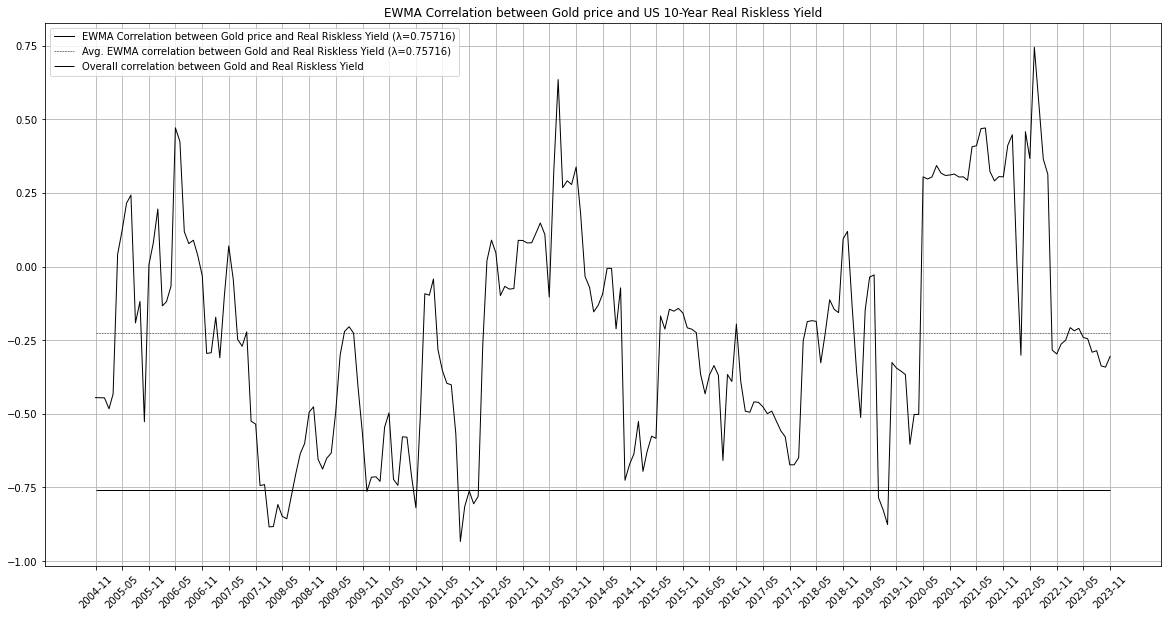

In [31]:
x = covariance_tracker_gold_riskless_yield.get_dates()[days_to_skip:] # Skipping the first 20 datapoints
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x, correlations_gold_riskless_yield[days_to_skip:],
        label='EWMA Correlation between Gold price and Real Riskless Yield (λ=%.5f)' % combined_ewma.lamda,
        linewidth=1, color='k')
ax.hlines(correlations_gold_riskless_yield[days_to_skip:].mean(),
          label='Avg. EWMA correlation between Gold and Real Riskless Yield (λ=%.5f)' % combined_ewma.lamda,
          xmin=x[0], xmax=x[-1], linestyle='--', linewidth=.5, color='k')
ax.hlines(overall_gold_real_yield_corr, label='Overall correlation between Gold and Real Riskless Yield',
          xmin=x[0], xmax=x[-1], linestyle='-', linewidth=1, color='k')
ax.legend(loc='upper left')
ax.grid(True)
ax.set_title('EWMA Correlation between Gold price and US 10-Year Real Riskless Yield')
ax.set_xticks(x[::6])
_ = ax.set_xticklabels(x[::6].strftime('%Y-%m'), rotation=45)

A more primitive way of calculating the correlation &mdash; just calculating it over the price changes between the two assets of a rolling window of 12 trading days. An approach based on EWMA is superior to it.

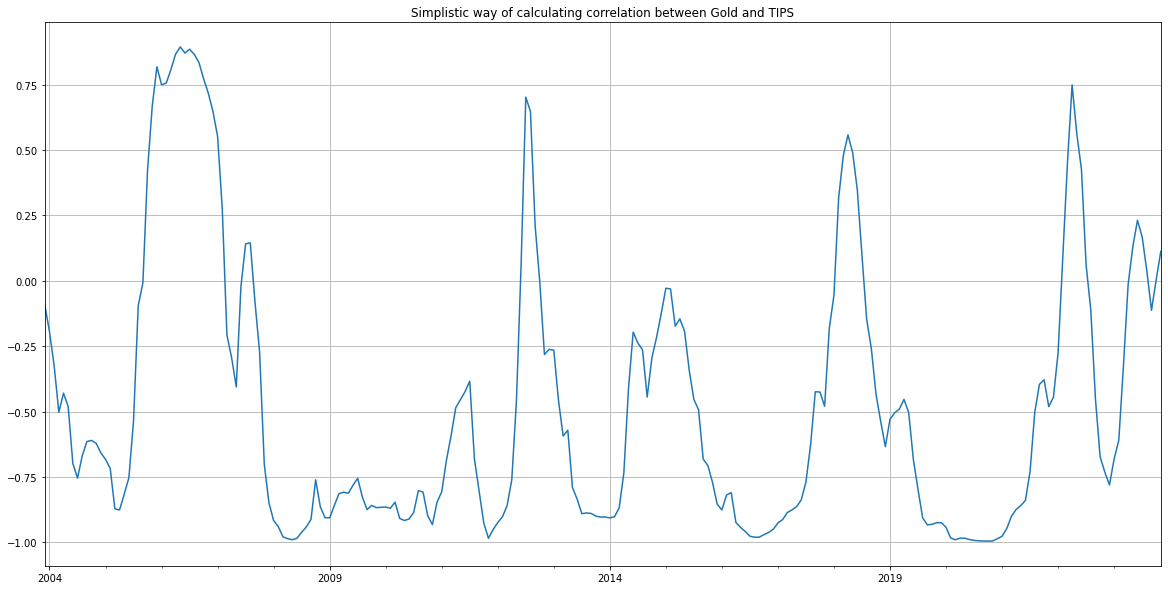

In [32]:
_ = asset_prices_gold.rolling(12).corr(riskless_yield).dropna().plot(figsize=(20,10), grid=True,
                        title='Simplistic way of calculating correlation between Gold and TIPS')

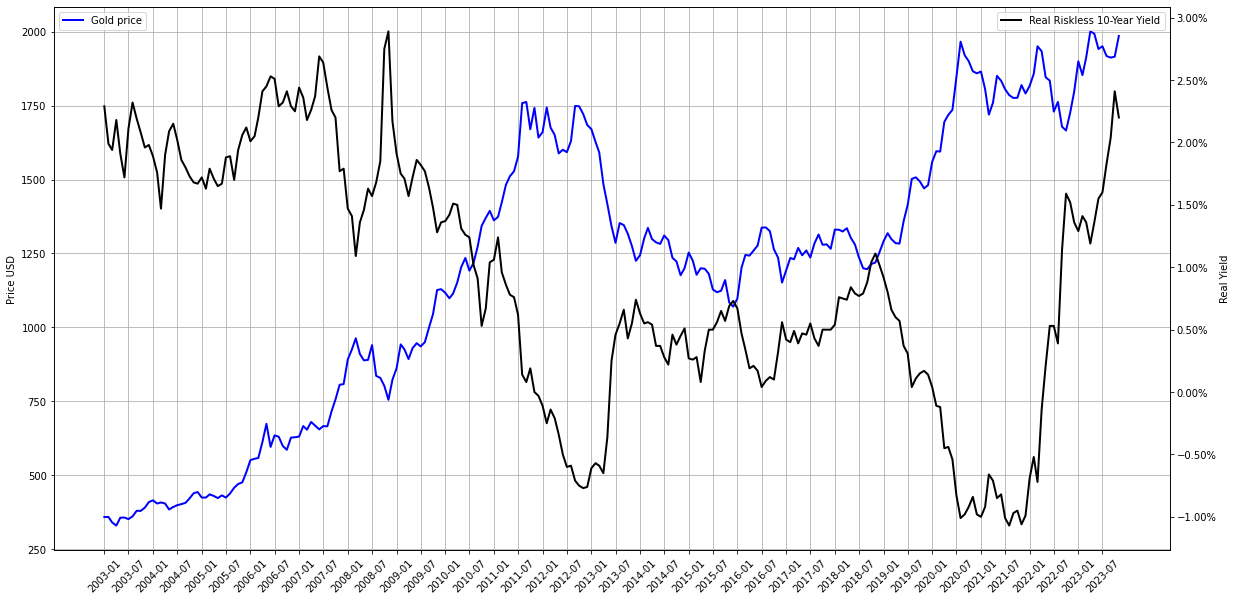

In [33]:
left_lbl, right_lbl = 'Price USD', 'Real Yield'

x = asset_prices.index 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, asset_prices.iloc[:,0],
        label='Gold price', linewidth=2, color='b')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, asset_prices.iloc[:,1],
        label='Real Riskless 10-Year Yield', linewidth=2, color='k')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True)
ax.set_ylabel(left_lbl)
ax2.set_ylabel(right_lbl)
ax.set_xticks(x[::6])
_ = ax.set_xticklabels(x[::6].strftime('%Y-%m'), rotation=45)

### Estimating correlation between Apple and SP500 using GARCH(1, 1)
Searching for ω, α, and β that maximize the likelihood of witnessing the given percentage changes in AAPL and SP500. <span style="color: red">**NB**:</span> the approach presented below &mdash; using GARCH(1, 1) for estimating parameters for correlations and volatilities tracking is not correct and mustn't be used.

In [ ]:
data = web.get_data_yahoo(['AAPL', '^GSPC'], start, end)

# Get rid of possible offset when aggregating data from different trading venues
asset_prices = data['Adj Close'].resample('D').first()

asset_prices_apple = asset_prices['AAPL']
asset_prices_sp500 = asset_prices['^GSPC']

# Searching for ω, α, and β that maximize the likelihood of witnessing the given percentage
# changes in AAPL and SP500.
combined_garch = parameter_estimators.GARCHParameterEstimator(asset_prices)

# Reusing the ω, α, and β found
sp500_vol_tracker = volatility_trackers.GARCHVolatilityTracker(
    combined_garch.omega, combined_garch.alpha, combined_garch.beta, asset_prices_sp500)
apple_vol_tracker = volatility_trackers.GARCHVolatilityTracker(
    combined_garch.omega, combined_garch.alpha, combined_garch.beta, asset_prices_apple)
covariance_tracker = covariance_trackers.GARCHCovarianceTracker(
    combined_garch.omega, combined_garch.alpha, combined_garch.beta, asset_prices)

[*********************100%***********************]  2 of 2 completed


Making an attempt to forecast future correlation between AAPL and SP500

In [ ]:
sp500_vols = sp500_vol_tracker.get_daily_volatilities()
apple_vols = apple_vol_tracker.get_daily_volatilities()
covariances = covariance_tracker.get_covariances()
correlations = covariances / (sp500_vols * apple_vols)

# Forecasting correlation between Apple and SP500 200 days into the future
future_sp500_vols = sp500_vol_tracker.get_volatility_forecast_for_next_n_days(200)
future_apple_vols = apple_vol_tracker.get_volatility_forecast_for_next_n_days(200)
future_covariances = covariance_tracker.get_covariance_forecast_for_next_n_days(200)
future_correlations = future_covariances / (future_sp500_vols * future_apple_vols)

long_term_correlation = covariance_tracker.get_long_term_covariance() \
    / (sp500_vol_tracker.get_long_term_volatility() * apple_vol_tracker.get_long_term_volatility())

### Visualizing the correlation between AAPL and SP500 using GARCH(1, 1)

In [ ]:
rescaled_asset_prices_apple = apple_vol_tracker.get_adj_close_prices() / asset_prices_apple[0]
rescaled_asset_prices_sp500 = sp500_vol_tracker.get_adj_close_prices() / asset_prices_sp500[0]

In [ ]:
x = apple_vol_tracker.get_dates()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, correlations,
        label='Correlation AAPL and SP500 (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)'
            % (combined_garch.omega, combined_garch.alpha, combined_garch.beta),
        linewidth=2, color='b')

ax.plot(future_correlations.index, future_correlations, label='Forecast correlation', linewidth=1, color='b')
ax.hlines(long_term_correlation,
          xmin=future_correlations.index[0], xmax=future_correlations.index[-1],
         label="Long-term correlation", linestyle='--')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, rescaled_asset_prices_apple, label=right_lbl + ' APPL', linewidth=1, color='g')
ax2.plot(x, rescaled_asset_prices_sp500, label=right_lbl + ' SP500', linewidth=1, color='c')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True)
ax.set_ylabel(left_lbl)
ax2.set_ylabel(right_lbl + ' (scaled to 1)')

**NB:** The long-term correlation seems suspiciously close to 1.0. This is because by reusing the same ω, α, and β,  I ended up with the same long-term volatility estimate for AAPL and SP500:

In [ ]:
print('Long-term volatility for AAPL: %.2f%%\nLong-term volatility for SP500: %.2f%%'
      % (apple_vol_tracker.get_annual_long_term_volatility() * 100,
         sp500_vol_tracker.get_annual_long_term_volatility() * 100))

This obviously doesn't make sense, which shows that the GARCH(1, 1) model as presented in the textbook to update variance-covariane matrices is not correct. John C. Hull makes a note in Section _11.3 Correlation and Covariance Matroces_:
> Using a GARCH model to update a variance-covariance matrix in a consistent way is trickier and requires a multivariate model.